# Spotify K Means Algorithm

## Import Packages

In [153]:
# imports

import json
import requests
from furl import furl
from math import ceil

# to save some typing
import pandas as pd
import numpy as np
import matplotlib

# to display plots in the notebook
%matplotlib inline
import matplotlib.pyplot as plt

# to enable get requests through python
import spotipy
from spotipy.oauth2 import SpotifyOAuth

Spotipy: https://spotipy.readthedocs.io/en/2.18.0/#authorization-code-flow

## Wrangling Spotify Data

In [ ]:
# GET request for all track ids
scope = "user-library-read"

sp = spotipy.Spotify(auth_manager=SpotifyOAuth(scope=scope))
track_ids = []


SAVED_TRACKS_LIMIT = 20
i = 0

print("num ids:", end=" ")

# for each API request of 20 tracks
while True: 
    response = sp.current_user_saved_tracks(offset=SAVED_TRACKS_LIMIT*i)

    for idx, item in enumerate(response['items']):
        track = item['track']
        track_ids.extend([track['id']])
#         print(idx, track['artists'][0]['name'], " – ", track['name'])

    # progress bar
    if(len(track_ids) % 100 == 0):
        print(len(track_ids), end=" ")
    
    # either end loop once no more tracks to add or increment counter
    if not response['next']:
        break
    
    i += 1
    
print("success!")
    
# ensure that all track ids are unique (not duplicating weirdly)
assert len(track_ids) == len(np.unique(track_ids)), f'Tracks ids not read in properly, as only {len(np.unique(track_ids))}/{len(track_ids)} track IDs are unique'

num ids: 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 

In [143]:
# get audio features for each track using track_ids

AUDIO_FEATURES_LIMIT = 100
num_requests = int(len(track_ids)/AUDIO_FEATURES_LIMIT)
remainder = len(track_ids)%AUDIO_FEATURES_LIMIT

assert num_requests*AUDIO_FEATURES_LIMIT+remainder == len(track_ids), f'math is wrong: {num_requests*AUDIO_FEATURES_LIMIT+remainder}, {len(track_ids)}'

# initialize lists
audio_features = []

print(f'going to {num_requests}...')

# read in audio features by 100s for all of track_ids (limit is 100)
for i in range(num_requests):
    # create range of track ids to use
    lo = i*AUDIO_FEATURES_LIMIT
    hi = (i+1)*AUDIO_FEATURES_LIMIT
    response = sp.audio_features(tracks=track_ids[lo:hi])

    # add to relevant list
    for j in range(len(response)):
        audio_features.extend([[response[j]['acousticness'], response[j]['danceability'], 
                              response[j]['energy'], response[j]['instrumentalness'], 
                              response[j]['liveness'], response[j]['speechiness'], 
                              response[j]['valence']]])

    # progress bar
    print(i, end =" ")

# get remaining 
if(remainder > 0):
    for j in range(0,remainder):
        audio_features.extend([[response[j]['acousticness'], response[j]['danceability'], 
                              response[j]['energy'], response[j]['instrumentalness'], 
                              response[j]['liveness'], response[j]['speechiness'], 
                              response[j]['valence']]])
    
print("success!")

assert len(track_ids) == len(audio_features), f'length of feature list is {len(audio_features)} while track_ids is {len(track_ids)}'

going to 52...
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 success!


In [144]:
# load all audio features data into dataframe
data = pd.DataFrame(audio_features, columns=['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'valence'])
data.head(5)

acousticness  danceability  energy  instrumentalness  liveness  \
0         0.149         0.644   0.811          0.000473    0.1700   
1         0.605         0.621   0.713          0.000008    0.1030   
2         0.366         0.746   0.765          0.001560    0.0799   
3         0.499         0.839   0.475          0.011400    0.3190   
4         0.324         0.604   0.573          0.101000    0.1030   

   speechiness  valence  
0       0.0517    0.817  
1       0.1020    0.609  
2       0.0540    0.972  
3       0.1900    0.667  
4       0.1890    0.759

My next job was to plot histograms and make sure that I had a decent distribution of values from 0 to 1.


Here, I made sure my process was working properly by validating my charts with https://www.klangspektrum.digital/home, which shows your spread of various traits. Below are my histograms, followed by some of these images for reference

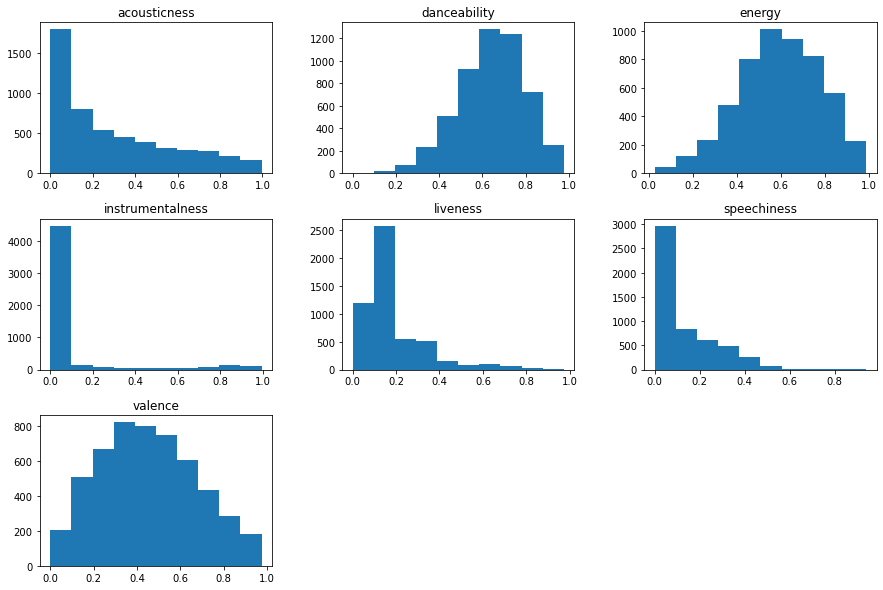

In [145]:
charts = data.hist(grid=False, bins=10, layout=(3,3), figsize=(15,10))

<img src="files/acousticness.png" width=400 height=130 style="float:left"/>
<img src="files/danceability.png" width=400 height=130/>
<img src="files/energy.png" width=400 height=130 style="float:left"/>
<img src="files/instrumentalness.png" width=400 height=130 />
<img src="files/liveness.png" width=400 height=130 style="float:left" />
<img src="files/speechiness.png" width=400 height=130 />
<img src="files/valence.png" width=400 height=130 style="float:left" />

## Determine Number of Clusters (Average Silhouette)

## Data Processing